<a href="https://colab.research.google.com/github/KirtiNayak11/SkinCancerDetection_EnsembleLearning/blob/main/SkinCancerDetection_EnsembleTechnique_WeightedAvg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Trained Models**

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
densenet_model = load_model("/content/drive/MyDrive/F1/Densenet_model.h5")

In [ ]:
resnet_model = load_model("/content/drive/MyDrive/F1/Resnet_model.h5")

In [ ]:
cnn_model = load_model("/content/drive/MyDrive/F1/CNN_model.h5")

**Setting Up Kaggle API Credentials**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

**Downloading the Multi-Cancer dataset**

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

100% 325M/325M [00:12<00:00, 30.5MB/s]
100% 325M/325M [00:12<00:00, 27.0MB/s]


**Extracting Multi-Cancer Dataset**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-malignant-vs-benign.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/skinCancerDetection')
zip_ref.close()


**Class Distribution Analysis for MultiCancer Test Dataset**

In [ ]:
import tensorflow as tf

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/skinCancerDetection/test',
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=True,
    label_mode="categorical"
)

Found 660 files belonging to 2 classes.


In [ ]:
class_names = test_ds.class_names
class_names

['benign', 'malignant']

In [ ]:
data_dir = '/content/drive/MyDrive/skinCancerDetection/test'

In [ ]:
import os
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

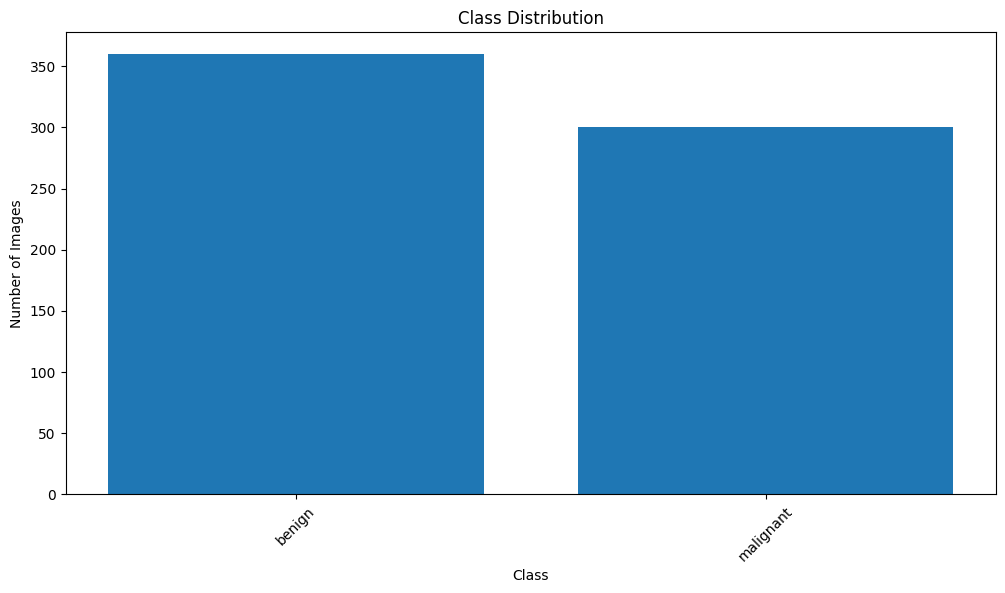

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0)

In [ ]:
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

**Average Ensemble Learning Technique**



1/1 [==============================] - 0s 210ms/step
weighted_average_malignant is  0.009541319062312445
weighted_average_begnin is  0.9904586474100748
actual label: benign
predicted label  benign


1/1 [==============================] - 0s 224ms/step
weighted_average_malignant is  0.78311554590861
weighted_average_begnin is  0.21688449382781982
actual label: malignant
predicted label  malignant


1/1 [==============================] - 0s 214ms/step
weighted_average_malignant is  0.9868892828623453
weighted_average_begnin is  0.013110744456450144
actual label: malignant
predicted label  malignant


1/1 [==============================] - 0s 210ms/step
weighted_average_malignant is  0.009303836772839228
weighted_average_begnin is  0.9906961917877197
actual label: benign
predicted label  benign


1/1 [==============================] - 0s 326ms/step
weighted_average_malignant is  0.4129677216211955
weighted_average_begnin is  0.5870322386423746
actual label: benign
predicted label  benig

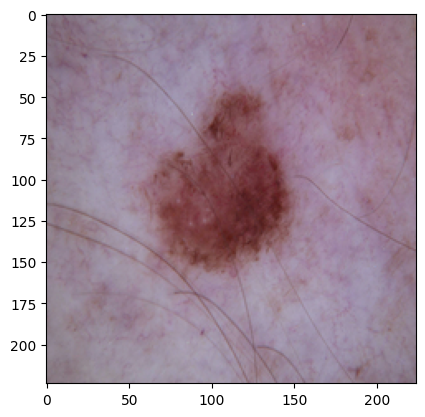

In [ ]:
for images, labels in test_ds.take(1):
        for i in range(5):
            image = images[i]
            actual_label_avg = tf.argmax(labels[i]).numpy()

            plt.imshow(image)
            print("\n")

            predictedValue_densenet = densenet_model.predict(np.expand_dims(image, axis=0))
            predictedValue_cnn = cnn_model.predict(np.expand_dims(image, axis=0))
            predictedValue_resnet = resnet_model.predict(np.expand_dims(image, axis=0))

            weighted_average_begnin = ((predictedValue_densenet[0][0] +
                  predictedValue_cnn[0][0] +
                  predictedValue_resnet[0][0]))/3

            weighted_average_malignant = ((predictedValue_densenet[0][1] +
                  predictedValue_cnn[0][1] +
                  predictedValue_resnet[0][1]))/3

            print("weighted_average_malignant is ",weighted_average_malignant)
            print("weighted_average_begnin is ",weighted_average_begnin)

            print("actual label:", class_names[actual_label_avg])
            threshold = 0.5

            if weighted_average_malignant>0.5:
                print("predicted label ", class_names[1])
            else:
                print("predicted label ", class_names[0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

true_labels = []

predicted_labels = []

for image_batch, labels_batch in test_ds:
    n= image_batch.shape[0]

    for i in range(n):

      predictedValue_densenet = densenet_model.predict(np.expand_dims(image_batch[i], axis=0))
      predictedValue_cnn = cnn_model.predict(np.expand_dims(image_batch[i], axis=0))
      predictedValue_resnet = resnet_model.predict(np.expand_dims(image_batch[i], axis=0))

      weighted_average_begnin = ((predictedValue_densenet[0][0] +
      predictedValue_cnn[0][0] +
      predictedValue_resnet[0][0]))/3

      weighted_average_malignant = ((predictedValue_densenet[0][1] +
      predictedValue_cnn[0][1] +
      predictedValue_resnet[0][1]))/3

      print("weighted_average_malignant is ",weighted_average_malignant)
      print("weighted_average_begnin is ",weighted_average_begnin)

      print("actual label:", class_names[actual_label_avg])
      threshold = 0.5

      if weighted_average_malignant>0.5:
                print("predicted label ", class_names[1])
                predicted_labels.append(1)
      if weighted_average_begnin>0.5:
                print("predicted label ", class_names[0])
                predicted_labels.append(0)

      label_index = tf.where(labels_batch[i] == 1).numpy()[0][0]
      true_labels.append(label_index)

1/1 [==============================] - 0s 328ms/step
weighted_average_malignant is  0.6913487116495768
weighted_average_begnin is  0.3086513082186381
actual label: benign
predicted label  malignant
1/1 [==============================] - 0s 221ms/step
weighted_average_malignant is  0.2509443362553914
weighted_average_begnin is  0.7490556240081787
actual label: benign
predicted label  benign
1/1 [==============================] - 0s 203ms/step
weighted_average_malignant is  0.9563935597737631
weighted_average_begnin is  0.04360644022623698
actual label: benign
predicted label  malignant
1/1 [==============================] - 0s 202ms/step
weighted_average_malignant is  0.009957810863852501
weighted_average_begnin is  0.9900422096252441
actual label: benign
predicted label  benign
1/1 [==============================] - 0s 213ms/step
weighted_average_malignant is  0.01030194821457068
weighted_average_begnin is  0.9896980921427408
actual label: benign
predicted label  benign
1/1 [==========

In [ ]:
cm_avg_weight = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm_avg_weight)

Confusion Matrix:
[[294  66]
 [ 19 281]]


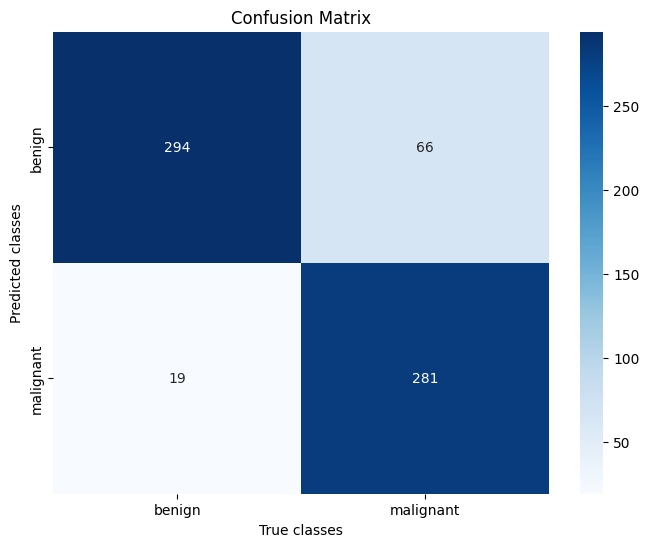

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm_avg_weight, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('True classes')
plt.ylabel('Predicted classes')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8712121212121212
Precision: 0.8804340092791538
Recall: 0.8712121212121212
F1-Score: 0.8713928373162556
Confusion Matrix:
[[294  66]
 [ 19 281]]
